In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [3]:
splits, info = tfds.load('horses_or_humans', as_supervised=True, with_info=True, 
                         split=['train[:80%]', 'train[80%:]', 'test'], data_dir='./data')

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 224

In [5]:
# Autograph pre-processing - resize-normalize an image
@tf.function
def map_fn(img, label):
    image_height = 224
    image_width = 224
    img = tf.image.resize(img, size=(image_height, image_width))
    img /= 255. 
    return img, label

In [6]:
## TEST
test_image, test_label = list(train_examples)[0]
test_result = map_fn(test_image, test_label)

print(test_result[0].shape)
print(test_result[1].shape)
del test_image, test_label, test_result

(224, 224, 3)
()


In [7]:
# train dataset
def prepare_dataset(train_examples, validation_examples, test_examples, num_examples, map_fn, batch_size):
    train_ds = train_examples.map(map_fn).shuffle(num_examples).batch(batch_size)
    valid_ds = validation_examples.map(map_fn).batch(batch_size)
    test_ds = test_examples.map(map_fn).batch(batch_size)
    
    return train_ds, valid_ds, test_ds

In [8]:
train_ds, valid_ds, test_ds = prepare_dataset(train_examples, validation_examples, test_examples, num_examples, map_fn, BATCH_SIZE)

In [9]:
## TEST
test_train_ds = list(train_ds)

print(len(test_train_ds))
print(test_train_ds[0][0].shape)
del test_train_ds

26
(32, 224, 224, 3)


In [10]:
# MODEL
MODULE_HANDLE = 'data/resnet_50_feature_vector'
model = tf.keras.Sequential([
    hub.KerasLayer(MODULE_HANDLE, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23561152  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,565,250
Trainable params: 4,098
Non-trainable params: 23,561,152
_________________________________________________________________


In [11]:
def set_adam_optimizer():    
    optimizer = tf.keras.optimizers.Adam()
    return optimizer

In [12]:
## TEST
test_optimizer = set_adam_optimizer()

print(type(test_optimizer))
del test_optimizer

<class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>


In [13]:
def set_sparse_cat_crossentropy_loss():    
    train_loss = tf.keras.losses.SparseCategoricalCrossentropy() 
    val_loss = tf.keras.losses.SparseCategoricalCrossentropy()     
    return train_loss, val_loss

In [14]:
## TEST
test_train_loss, test_val_loss = set_sparse_cat_crossentropy_loss()

print(type(test_train_loss))
print(type(test_val_loss))
del test_train_loss, test_val_loss

<class 'tensorflow.python.keras.losses.SparseCategoricalCrossentropy'>
<class 'tensorflow.python.keras.losses.SparseCategoricalCrossentropy'>


In [15]:
def set_sparse_cat_crossentropy_accuracy():    
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()     
    return train_accuracy, val_accuracy

In [16]:
## TEST
test_train_accuracy, test_val_accuracy = set_sparse_cat_crossentropy_accuracy()

print(type(test_train_accuracy))
print(type(test_val_accuracy))
del test_train_accuracy, test_val_accuracy

<class 'tensorflow.python.keras.metrics.SparseCategoricalAccuracy'>
<class 'tensorflow.python.keras.metrics.SparseCategoricalAccuracy'>


In [17]:
optimizer = set_adam_optimizer()
train_loss, val_loss = set_sparse_cat_crossentropy_loss()
train_accuracy, val_accuracy = set_sparse_cat_crossentropy_accuracy()

In [18]:
# access GPU
device = '/gpu:0' if tf.config.list_physical_devices('GPU') else '/cpu:0'
EPOCHS = 3

# Custom training step
def train_one_step(model, optimizer, x, y, train_loss, train_accuracy):
    '''
    Trains on a batch of images for one step.
    
    Args:
        model (keras Model) -- image classifier
        optimizer (keras Optimizer) -- optimizer to use during training
        x (Tensor) -- training images
        y (Tensor) -- training labels
        train_loss (keras Loss) -- loss object for training
        train_accuracy (keras Metric) -- accuracy metric for training
    '''
    with tf.GradientTape() as tape:            
        predictions = model(x)        
        loss = train_loss(y, predictions)
   
    grads = tape.gradient(loss, model.trainable_weights)  
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_accuracy.update_state(y, predictions)
    return loss

In [19]:
## TEST
def base_model():
    inputs = tf.keras.layers.Input(shape=(2))
    x = tf.keras.layers.Dense(64, activation='relu')(inputs)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

test_model = base_model()

test_optimizer = set_adam_optimizer()
test_image = tf.ones((2,2))
test_label = tf.ones((1,))
test_train_loss, _ = set_sparse_cat_crossentropy_loss()
test_train_accuracy, _ = set_sparse_cat_crossentropy_accuracy()

test_result = train_one_step(test_model, test_optimizer, test_image, test_label, test_train_loss, test_train_accuracy)
print(test_result)

del test_result, test_model, test_optimizer, test_image, test_label, test_train_loss, test_train_accuracy

tf.Tensor(0.6931472, shape=(), dtype=float32)


In [20]:
# Enable autograph on the training loop - tf.function
@tf.function
def train(model, optimizer, epochs, device, train_ds, train_loss, train_accuracy, valid_ds, val_loss, val_accuracy):
    '''
    Performs the entire training loop. Prints the loss and accuracy per step and epoch.
    
    Args:
        model (keras Model) -- image classifier
        optimizer (keras Optimizer) -- optimizer to use during training
        epochs (int) -- number of epochs
        train_ds (tf Dataset) -- the train set containing image-label pairs
        train_loss (keras Loss) -- loss function for training
        train_accuracy (keras Metric) -- accuracy metric for training
        valid_ds (Tensor) -- the val set containing image-label pairs
        val_loss (keras Loss) -- loss object for validation
        val_accuracy (keras Metric) -- accuracy metric for validation
    '''
    step = 0
    loss = 0.0
    for epoch in range(epochs):
        for x, y in train_ds:    
            step += 1
            with tf.device(device_name=device): # access GPU                
                loss = train_one_step(model, optimizer, x, y, train_loss, train_accuracy)
              
            tf.print('Step', step, 
                   ': train loss', loss, 
                   '; train accuracy', train_accuracy.result())

        with tf.device(device_name=device):
            for x, y in valid_ds:                
                y_pred = model(x)
                loss = val_loss(y, y_pred)
                val_accuracy(y, y_pred)        
       
        tf.print('val loss', loss, '; val accuracy', val_accuracy.result())        

In [21]:
train(model, optimizer, EPOCHS, device, train_ds, train_loss, train_accuracy, valid_ds, val_loss, val_accuracy)

Step 1 : train loss 0.516057789 ; train accuracy 0.65625
Step 2 : train loss 0.197591156 ; train accuracy 0.8125
Step 3 : train loss 0.141589761 ; train accuracy 0.864583313
Step 4 : train loss 0.05714304 ; train accuracy 0.8984375
Step 5 : train loss 0.0652074814 ; train accuracy 0.91875
Step 6 : train loss 0.0310707726 ; train accuracy 0.932291687
Step 7 : train loss 0.0219821259 ; train accuracy 0.941964269
Step 8 : train loss 0.0129072182 ; train accuracy 0.94921875
Step 9 : train loss 0.0118642515 ; train accuracy 0.954861104
Step 10 : train loss 0.00959129073 ; train accuracy 0.959375
Step 11 : train loss 0.00879315287 ; train accuracy 0.963068187
Step 12 : train loss 0.00642730761 ; train accuracy 0.966145813
Step 13 : train loss 0.0790208057 ; train accuracy 0.966346145
Step 14 : train loss 0.00338492589 ; train accuracy 0.96875
Step 15 : train loss 0.00177660852 ; train accuracy 0.970833361
Step 16 : train loss 0.00145881064 ; train accuracy 0.97265625
Step 17 : train loss 0.0

In [22]:
# Evaluation

test_imgs = []
test_labels = []

predictions = []
with tf.device(device_name=device):
    for images, labels in test_ds:
        
        preds = model(images)
        preds = preds.numpy()
        predictions.extend(preds)

        test_imgs.extend(images.numpy())
        test_labels.extend(labels.numpy())

In [23]:
class_names = ['horse', 'human']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)

    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
 
    print(true_label)
  
    # show the image and overlay the prediction
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

0


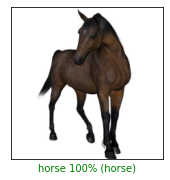

In [24]:
index = 55
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()